In [ ]:
import pandas as pd
import numpy as np
import time as tm
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# csv data file path.
wdbc_data_File_Path = "/content/gdrive/MyDrive/wdbc_csv.csv"

# Pandas reading csv file and taking data from that.
data_file = pd.read_csv(wdbc_data_File_Path)



# Takes 1st 550 datasets and 30 columns of data from csv file and stores in X.
data = data_file.copy()

data_new = data[['V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','V29','V30']].copy()

# Divivding data values with a number so we can get values in smaller range. We always need to divide data with exact
# same number while testing
data_new = data_new/data_new.max()
X_train = data_new.iloc[:500]
X_test = data_new.iloc[500:]

# Takes values from last (Class) column and stores as binary i.e 1= 0 and 2= 1 and store in data['class']
data['class'] = data_file['Class'].apply(lambda x : 0 if x == 1 else 1)


# Takes 1st 500 values from data['class'] and stores in y_train.
y_train = data['class'].iloc[:500].copy()
y_test = data['class'].iloc[500:]
y_test = y_test.values.reshape(-1,1)

# Forming different layers here.
def Layers(NumberOfInputs, NumberOfNeuronsInNextLayer):
  np.random.seed(1)
  weights = np.random.randn(NumberOfInputs, NumberOfNeuronsInNextLayer)
  biases = np.random.randn(NumberOfNeuronsInNextLayer)
  return weights, biases

# Multiplying inputs with weights and adding biases to them.
def LayersInputsProduct(Inputs, weight, biases):
  output_matrix_of_layer = np.dot(Inputs, weight) + biases
  return output_matrix_of_layer

def ReLuActivation(inputs):
  ReLU_activation_output = np.maximum(0, inputs)
  return ReLU_activation_output

def derRelu(z):
  z[z<=0] = 0
  z[z>0] = 1
  return z

def SigmoidActivation(inputs):
  Sigmoid_activation_output = 1 / (1 + np.exp(-inputs))
  return Sigmoid_activation_output

# Binary-cross-Entropy to calculate loss in our actual and predicted values
# As this formula to calculate binary-cross-entropy include log function. And log(0) is infinity. what if
# we got an output value equal to zero. that will cause an error. To avoid that error we use a range
# between 1e-7 to 1-1e7. So that our predicted values lower or higher than this would clip at the
# edges of range. For this we used numpy.clip function.

def Binary_Cross_Entropy(y_true, y_predicted):
  # To make y_true a 2d array or 1-column matrix to fit in cost-formula.
  numberOfSamples = len(y_true)
  y_predicted_clipped = np.clip(y_predicted, 1e-7, 1-1e-7)

  # Actually I am breaking that algorithm in two parts for easy understanding. Then join them together in 3rd line below.
  part1 = y_true * np.log(y_predicted_clipped + 1e-7)
  part2 = (1-y_true) * np.log(1-y_predicted_clipped + 1e-7)
  MeanValue = -1/numberOfSamples *np.sum(part1 + part2)
  return MeanValue




Mounted at /content/gdrive


In [ ]:
#Defining arrays for data storage
avgAcc = []
avgtme = []
stdAcc = []
stdTme = []
#looping while adjusting hyper parameters to allow for a quick grid search of results
for hp in range(18):
  #Hyper Parameters
  alpha =  0.012# + (0.001 * hp)
  iter = 1600 + (200 * hp)
  Neurons = 1  +hp


  #Defining variables
  Loss_output = []
  accuracy = []
  timearr = []
  #Batch sizes
  Bach_Size = 10

  #Running each experiment with each hyper parameter 10 times to generate averages
  for TR in range (10):
    # Training start time.
    startTime = tm.time()
    #X_train.shape[1] is input layer
    #Hidden layer
    layer1Weights, layer1biases = Layers(X_train.shape[1], Neurons)

    #Output layer
    layer2Weights, layer2biases = Layers(layer1Weights.shape[1], 1)




    Chunk_Start = 0
    Chunk_End = Bach_Size

    for i in range(iter):
      X = X_train.iloc[Chunk_Start:Chunk_End]
      y = y_train.iloc[Chunk_Start:Chunk_End]
      y = y.values.reshape(-1,1)
      Chunk_Start += Bach_Size
      Chunk_End += Bach_Size

    # 50 is epoch size. after 50 epochs we process all data in dataset then for more accuracy we reset chunk sizes to do process again.
      if i%50 == 0:
        Chunk_Start = 0
        Chunk_End = Bach_Size

      layer1output = LayersInputsProduct(X, layer1Weights, layer1biases)
      layer1outputafterActivation = ReLuActivation(layer1output)

      # For binary output it is best to choose sigmoid activation function and have one neuron.
      # ActivationOfLayer1 will return the number of columns or number of features in dataset returned from ActivationOfLayer1.

      layer2output = LayersInputsProduct(layer1outputafterActivation, layer2Weights, layer2biases)
      layer2outputafterActivation = SigmoidActivation(layer2output)
      layer2outputafterActivation = layer2outputafterActivation.astype(float)

      loss = Binary_Cross_Entropy(y, layer2outputafterActivation)

      ActL2Inverse = 1 - layer2outputafterActivation
      yIverse = 1 - y

      # Finding derivative of loss with respect to weights and biases.
      # Gradient descent of output layer and weights of output layer
      DerWrtLayer2outputafterActivation = np.divide(yIverse, (ActL2Inverse + 1e-7 )) - np.divide(y, (layer2outputafterActivation  + 1e-7))
      DerWrtSigmoid = layer2outputafterActivation * (ActL2Inverse)
      DerOfLosWrtLayer2output = DerWrtLayer2outputafterActivation * DerWrtSigmoid

      # Gradient descent of hidden layer and weights of hidden layer.
      DerWrtLayer1outputafterActivation = DerOfLosWrtLayer2output.dot(layer2Weights.T)
      DerWrtLayer2Weights = layer1outputafterActivation.T.dot(DerOfLosWrtLayer2output)
      DerWrtLayer2biases = np.sum(DerOfLosWrtLayer2output, axis=0, keepdims=True)

      DerWrtLayer1output = DerWrtLayer1outputafterActivation * derRelu(layer1output)
      DerWrtLayer1Weights = X.values.T.dot(DerWrtLayer1output)
      DerWrtLayer1biases = np.sum(DerWrtLayer1output, axis=0, keepdims=True)

      #updating the weights and bias
      layer1Weights = layer1Weights - alpha * DerWrtLayer1Weights
      layer2Weights = layer2Weights - alpha * DerWrtLayer2Weights
      layer1biases = layer1biases - alpha * DerWrtLayer1biases
      layer2biases = layer2biases - alpha * DerWrtLayer2biases

      Loss_output.append(loss)

    # Training end time.
  # print("Total traing time: "+ str(tm.time() - startTime) + "s.")

    layer1output = LayersInputsProduct(X_test.values, layer1Weights, layer1biases)
    layer1outputafterActivation = ReLuActivation(layer1output)

    layer2output = LayersInputsProduct(layer1outputafterActivation, layer2Weights, layer2biases)
    layer2outputafterActivation = SigmoidActivation(layer2output)
    y_predict = np.round(layer2outputafterActivation)

    accuracy.append (sum(y_test == y_predict) / len(y_test) * 100)
    timearr.append ((tm.time() - startTime))
    #print(str(accuracy[TR]) +" , " + str(tm.time() - startTime))

  avgAcc.append(sum(accuracy)/10)
  avgtme.append(sum(timearr)/10)
  stdTme.append(np.std(timearr))
  stdAcc.append(np.std(accuracy))
print("Average")
print("Accuracy , Time Taken")
for a in range(10):
  print("{} , {}".format(avgAcc[a],avgtme[a]))

print("Standard Deviation")
print("Accuracy , Time Taken")
for s in range(10):
  print("{} , {}".format(stdAcc[s],stdTme[s]))


Average
Accuracy , Time Taken
[75.36231884] , 0.39790232181549073
[98.55072464] , 0.4667768716812134
[98.55072464] , 0.5171295404434204
[98.55072464] , 0.5706687211990357
[98.55072464] , 0.6207310676574707
[98.55072464] , 0.6858733892440796
[100.] , 0.7351617097854615
[100.] , 0.788876223564148
[100.] , 0.855895733833313
[100.] , 0.913771104812622
Standard Deviation
Accuracy , Time Taken
0.0 , 0.006826331387643612
1.4210854715202004e-14 , 0.005540300259985526
1.4210854715202004e-14 , 0.00742020435814105
1.4210854715202004e-14 , 0.02017079457565268
1.4210854715202004e-14 , 0.012431387808756376
1.4210854715202004e-14 , 0.017453191905251256
0.0 , 0.008971501082188556
0.0 , 0.006105706885172927
0.0 , 0.010476728251311957
0.0 , 0.007605520522489127


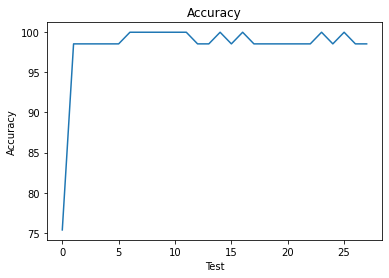

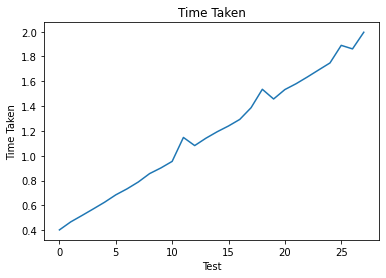

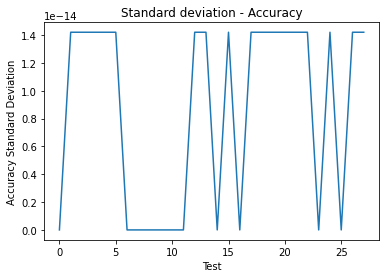

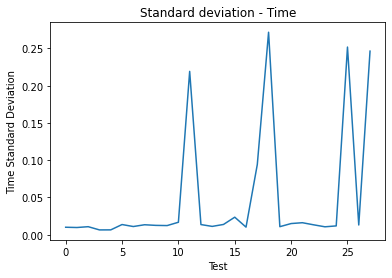

In [ ]:
#print(layer1Weights)

plt.plot(avgAcc)
plt.title("Accuracy")
plt.xlabel("Test")
plt.ylabel("Accuracy")
plt.show()

plt.plot(avgtme)
plt.title("Time Taken")
plt.xlabel("Test")
plt.ylabel("Time Taken")
plt.show()

plt.plot(stdAcc)
plt.title("Standard deviation - Accuracy")
plt.xlabel("Test")
plt.ylabel("Accuracy Standard Deviation")
plt.show()

plt.plot(stdTme)
plt.title("Standard deviation - Time")
plt.xlabel("Test")
plt.ylabel("Time Standard Deviation")
plt.show()


In [ ]:
accuracy = int(sum(y_test == y_predict) / len(y_test) * 100)
print("Accuracy: " + str(accuracy) +"%")

Accuracy: 98%


We have taken 500 (about 87%) data sets for training and 69 sets for testing (about 13%). After testing we got 91% accuracy.

In [ ]:
TP = 0
TN = 0
FP = 0
FN = 0

for t,p in zip(y_test, y_predict):
    if (t == 0 and  p == 0):
        TP = TP + 1
    elif (t == 1 and p == 1):
        TN = TN + 1
    elif (t == 0 and p == 1):
        FN = FN + 1
    elif (t == 1 and p == 0):
        FP = FP + 1

print("True Positives (Actually no cancer and NN shows no cancer): ", TP)
print("True Negatives (Actually cancer and NN shows cancer): ", TN)
print("False Positives (Actually cancer but NN shows no cancer): ", FP)
print("False Negatives (Actually no cancer but NN shows cancer): ", FN)

True Positives (Actually no cancer and NN shows no cancer):  52
True Negatives (Actually cancer and NN shows cancer):  17
False Positives (Actually cancer but NN shows no cancer):  0
False Negatives (Actually no cancer but NN shows cancer):  0
